In [59]:
import os.path as osp
import pyrootutils

pyrootutils.setup_root(
    search_from=osp.abspath(''),
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,  # add to system path
    dotenv=True,      # load environment variables .env file
    cwd=True,         # change cwd to root
)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


PosixPath('/Users/mlle/Repos/grow-ai/rise-gen')

In [60]:
import torch
import matplotlib.pyplot as plt

from model.vae.vnca import VNCA
from model.vae.star_vae import StarVAE
from sim.builder import SimBuilder
import utils.plot as viz

torch.autograd.set_grad_enabled(False);

In [110]:
vnca = VNCA.load_from_checkpoint('data/ckpt/vnca/v2-epoch=47-val_loss=0.572.ckpt').eval()
vae = StarVAE.load_from_checkpoint('data/ckpt/vae/downloaded.ckpt').eval()

In [86]:
VOXEL_SIZE, MAX_TORQUE = 0.01, 6

def build_robot(voxels):
    builder = SimBuilder(
            voxel_size=VOXEL_SIZE,
            valid_min_rigid_ratio=0.2,
            valid_min_joint_num=2,
            valid_max_connected_components=1,
            min_rigid_volume=100,
            hinge_torque=MAX_TORQUE,
        )
    
    builder.build(
        voxels,
        save_history=False,
        save_h5_history=False,
        print_summary=True
    )

    return builder

def viz_robot(robot):
    fig = plt.figure(figsize=(18, 6))
    axs = fig.subplots(1, 3, subplot_kw={"projection": "3d"})

    robot.visualize(
        is_not_empty_ax=axs[0],
        is_rigid_ax=axs[1],
        segmentation_ax=axs[2],
    )

    return fig

def generate_robots(vnca, n):
    return vnca.get_samples(n)  

# Plotting examples

In [87]:
TOTAL_ROBOTS = 10

voxel_logits = generate_robots(vnca, TOTAL_ROBOTS)
example_robots = [build_robot(vl) for vl in voxel_logits]

[robot] Build failed, invalid reason: Below min rigid ratio 0.2, Ratio: 0.1849689440993789
[robot] Build failed, invalid reason: Below min rigid ratio 0.2, Ratio: 0.14461363081182313
[robot] Build failed, invalid reason: Below min rigid ratio 0.2, Ratio: 0.18361471650239095
[robot] Build failed, invalid reason: Below min rigid ratio 0.2, Ratio: 0.1504501555082665
[robot] Voxel num: 16684 rigid segment num: 6 joint num: 5
[robot] Build failed, invalid reason: Below min rigid ratio 0.2, Ratio: 0.1379420070800684
[robot] Voxel num: 18163 rigid segment num: 5 joint num: 4
[robot] Voxel num: 9438 rigid segment num: 5 joint num: 4
[robot] Build failed, invalid reason: Below min rigid ratio 0.2, Ratio: 0.15281812899477049
[robot] Build failed, invalid reason: Below min rigid ratio 0.2, Ratio: 0.19608635160001794


In [88]:
valid = list(map(lambda x: x.log['is_valid'], example_robots))
valid_idx = [i for i, x in enumerate(valid) if x]
print(valid)
print(valid_idx)

[False, False, False, False, True, False, True, True, False, False]
[4, 6, 7]


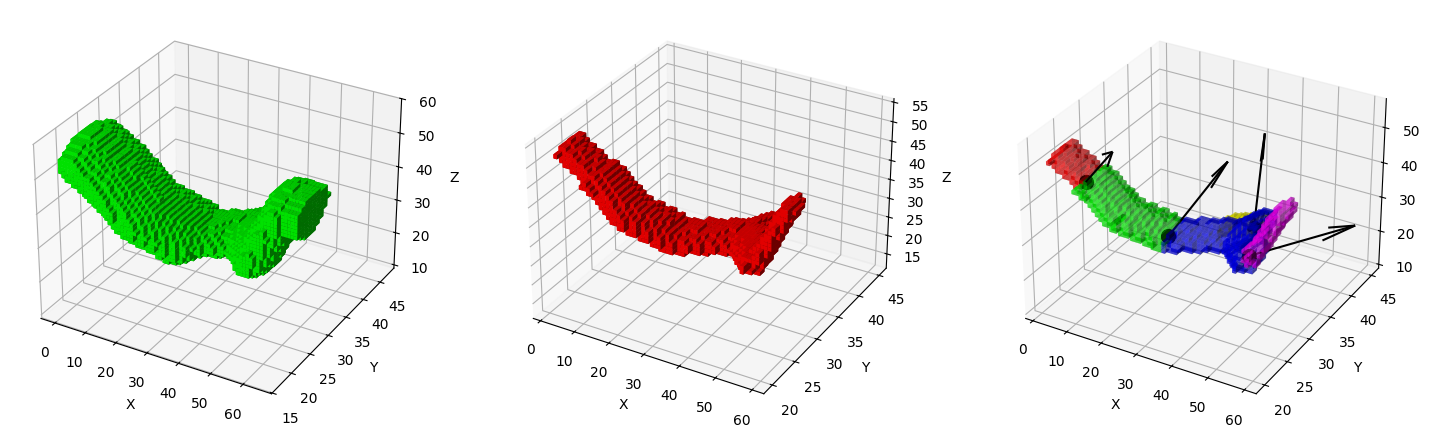

In [108]:
viz_robot(example_robots[valid_idx[2]]);

# Plotting VAE reconstructions

[robot] Voxel num: 21499 rigid segment num: 7 joint num: 6
[robot] Voxel num: 20294 rigid segment num: 5 joint num: 4
[robot] Voxel num: 12400 rigid segment num: 5 joint num: 4


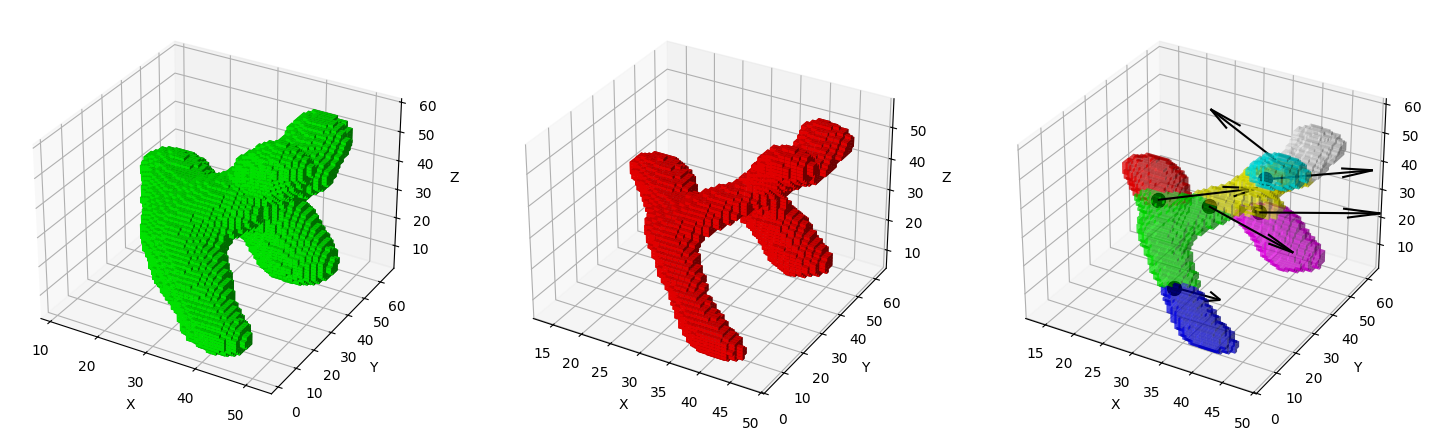

In [100]:
x = voxel_logits[valid_idx]
recons = vae.forward(x)

vae_recons = [build_robot(x) for x in recons]

viz_robot(vae_recons[0]);

# Plotting VNCA reconstructions

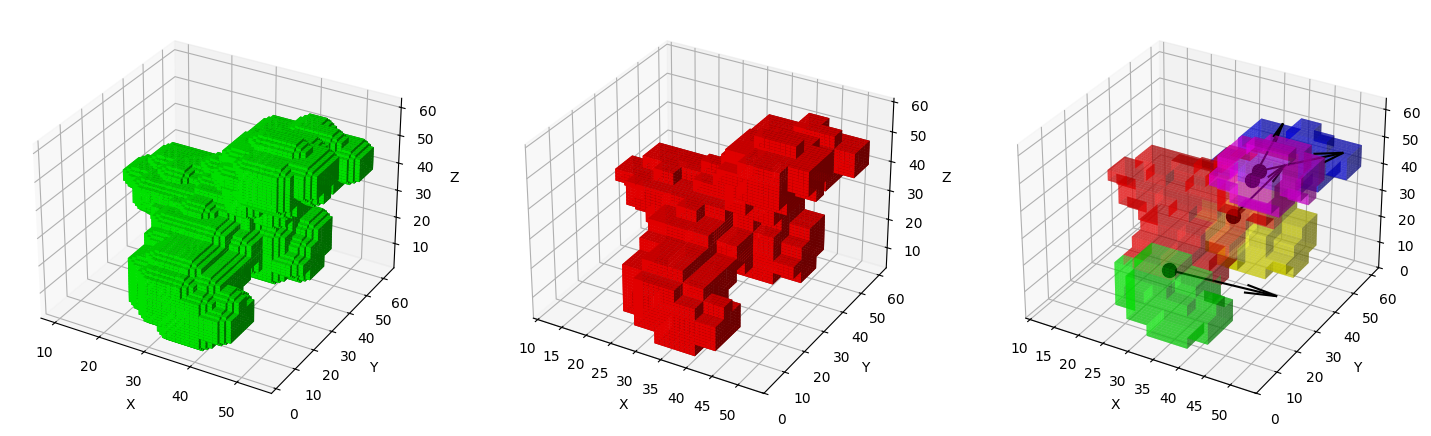

In [113]:
# x = voxel_logits[valid_idx]
# vnca_recons = vnca.forward(x)[0]

# vnca_robots = [build_robot(x) for x in recons]

viz_robot(vnca_robots[0]);